<a href="https://colab.research.google.com/github/dyaccu/Hackathon2025_Proyecto3_FlightOnTime/blob/main/Evaluacion_de_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧾 Celda 1 (Markdown) — Título y objetivo

## Modelos no lineales (Árboles) — Predicción de retrasos

**Objetivo:** Evaluar si un modelo no lineal más complejo (Random Forest) mejora el desempeño frente a un Árbol de Decisión para predecir `retraso` (1 = sí, 0 = no).

**Qué se evalúa:**
- Accuracy, Precision, Recall, F1-score
- Matriz de confusión (FP vs FN)
- Diferencia entre performance en Train vs Test (overfitting)
- Importancia de variables (feature importance)

---


# ⚙️ Celda 2 (Código) — Imports

In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

sns.set_style("whitegrid")


# 📦 Celda 3 (Código) — Carga y chequeo rápido

In [12]:
# URL Raw del dataset en GitHub
URL_DATASET = "https://raw.githubusercontent.com/NoCountry-vuelos-Team/flight-delay-DS/refs/heads/main/dataset/archivo_limpio.csv"
df = pd.read_csv(URL_DATASET)

print(df.shape)
display(df.head())
print("\nTipos de datos:")
print(df.dtypes)

print("\nDistribución del target (retraso):")
print(df["retraso"].value_counts())
print("\nProporción del target (retraso):")
print(df["retraso"].value_counts(normalize=True))


(120000, 9)


,aerolinea,origen,destino,distancia_km,retraso,anio,mes,es_fin_semana,bloque_horario
0,IB,MAD,EZE,7652,0,2025,1,0,madrugada
1,G3,GRU,MIA,9813,1,2025,1,0,madrugada
2,AA,GRU,EZE,2447,0,2025,1,0,madrugada
3,G3,AEP,EZE,4744,1,2025,1,0,madrugada
4,G3,MAD,MIA,8372,1,2025,1,0,madrugada



Tipos de datos:
aerolinea         object
origen            object
destino           object
distancia_km       int64
retraso            int64
anio               int64
mes                int64
es_fin_semana      int64
bloque_horario    object
dtype: object

Distribución del target (retraso):
retraso
0    75879
1    44121
Name: count, dtype: int64

Proporción del target (retraso):
retraso
0    0.632325
1    0.367675
Name: proportion, dtype: float64


# 🧩 Celda 4 (Código) — Features/Target + split estratificado

In [13]:
X = df.drop("retraso", axis=1)
y = df["retraso"]

cat_features = X.select_dtypes(include="object").columns.tolist()
num_features = X.select_dtypes(exclude="object").columns.tolist()

print("Categóricas:", cat_features)
print("Numéricas:", num_features)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("\nShapes:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)


Categóricas: ['aerolinea', 'origen', 'destino', 'bloque_horario']
Numéricas: ['distancia_km', 'anio', 'mes', 'es_fin_semana']

Shapes:
X_train: (84000, 8) X_test: (36000, 8)


# 🛠️ Celda 5 (Código) — Preprocesamiento (OneHot + passthrough)

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)


# 📏 Celda 6 (Código) — Funciones de evaluación (métricas + FP/FN)

In [15]:
def evaluar_modelo(nombre, pipeline, X_train, y_train, X_test, y_test):
    # Fit
    pipeline.fit(X_train, y_train)

    # Predicciones
    y_pred_train = pipeline.predict(X_train)
    y_pred_test  = pipeline.predict(X_test)

    # Métricas (binarias)
    metrics = {
        "Modelo": nombre,
        "Train Accuracy": accuracy_score(y_train, y_pred_train),
        "Test Accuracy": accuracy_score(y_test, y_pred_test),
        "Test Precision": precision_score(y_test, y_pred_test, zero_division=0),
        "Test Recall": recall_score(y_test, y_pred_test, zero_division=0),
        "Test F1": f1_score(y_test, y_pred_test, zero_division=0),
    }

    # Matriz de confusión y desglose
    cm = confusion_matrix(y_test, y_pred_test)
    tn, fp, fn, tp = cm.ravel()
    metrics.update({
        "TN": tn, "FP": fp, "FN": fn, "TP": tp
    })

    return metrics, y_pred_test, cm


def mostrar_matriz_confusion(cm, titulo):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(titulo)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()


# 🌳 Celda 7 (Código) — Experimentos: Decision Tree (profundidad)

In [16]:
dt_depths = [3, 5, 8, None]  # pruebas básicas

resultados = []

for depth in dt_depths:
    dt_pipeline = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", DecisionTreeClassifier(max_depth=depth, random_state=42))
    ])

    nombre = f"DecisionTree max_depth={depth}"
    res, y_pred, cm = evaluar_modelo(nombre, dt_pipeline, X_train, y_train, X_test, y_test)
    resultados.append(res)

df_resultados_dt = pd.DataFrame(resultados).sort_values(by="Test F1", ascending=False)
df_resultados_dt.reset_index(drop=True, inplace=True)

print("=== Resultados Decision Tree (ordenados por Test F1) ===")
display(df_resultados_dt)


=== Resultados Decision Tree (ordenados por Test F1) ===


,Modelo,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1,TN,FP,FN,TP
0,DecisionTree max_depth=3,0.845667,0.846694,0.820234,0.746676,0.781728,20598,2166,3353,9883
1,DecisionTree max_depth=5,0.845774,0.846639,0.820204,0.746525,0.781632,20598,2166,3355,9881
2,DecisionTree max_depth=8,0.846607,0.846222,0.820033,0.745316,0.780891,20599,2165,3371,9865
3,DecisionTree max_depth=None,0.999976,0.735500,0.637352,0.651028,0.644117,17861,4903,4619,8617


# 🌲 Celda 8 (Código) — Experimentos: Random Forest (n_estimators + depth)

In [17]:
rf_configs = [
    {"n_estimators": 100, "max_depth": 10},
    {"n_estimators": 300, "max_depth": 10},
    {"n_estimators": 200, "max_depth": 15},
    {"n_estimators": 300, "max_depth": None},  # más flexible (puede sobreajustar)
]

resultados_rf = []

for cfg in rf_configs:
    rf_pipeline = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=cfg["n_estimators"],
            max_depth=cfg["max_depth"],
            random_state=42,
            n_jobs=-1
        ))
    ])

    nombre = f"RandomForest n={cfg['n_estimators']} depth={cfg['max_depth']}"
    res, y_pred, cm = evaluar_modelo(nombre, rf_pipeline, X_train, y_train, X_test, y_test)
    resultados_rf.append(res)

df_resultados_rf = pd.DataFrame(resultados_rf).sort_values(by="Test F1", ascending=False)
df_resultados_rf.reset_index(drop=True, inplace=True)

print("=== Resultados Random Forest (ordenados por Test F1) ===")
display(df_resultados_rf)


=== Resultados Random Forest (ordenados por Test F1) ===


,Modelo,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1,TN,FP,FN,TP
0,RandomForest n=100 depth=10,0.845667,0.846722,0.820249,0.746751,0.781776,20598,2166,3352,9884
1,RandomForest n=300 depth=10,0.845655,0.846722,0.820249,0.746751,0.781776,20598,2166,3352,9884
2,RandomForest n=200 depth=15,0.859488,0.846056,0.821119,0.743200,0.780219,20621,2143,3399,9837
3,RandomForest n=300 depth=None,0.999976,0.828639,0.793846,0.721215,0.755790,20285,2479,3690,9546


# 🥇 Celda 9 (Código) — Comparación final + selección del mejor modelo (por Test F1)

In [18]:
df_all = pd.concat([df_resultados_dt, df_resultados_rf], ignore_index=True)
df_all = df_all.sort_values(by="Test F1", ascending=False).reset_index(drop=True)

print("=== Comparación total (DT + RF) por Test F1 ===")
display(df_all)

best_model_name = df_all.loc[0, "Modelo"]
print("\nMejor modelo por Test F1:", best_model_name)


=== Comparación total (DT + RF) por Test F1 ===


,Modelo,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1,TN,FP,FN,TP
0,RandomForest n=300 depth=10,0.845655,0.846722,0.820249,0.746751,0.781776,20598,2166,3352,9884
1,RandomForest n=100 depth=10,0.845667,0.846722,0.820249,0.746751,0.781776,20598,2166,3352,9884
2,DecisionTree max_depth=3,0.845667,0.846694,0.820234,0.746676,0.781728,20598,2166,3353,9883
3,DecisionTree max_depth=5,0.845774,0.846639,0.820204,0.746525,0.781632,20598,2166,3355,9881
4,DecisionTree max_depth=8,0.846607,0.846222,0.820033,0.745316,0.780891,20599,2165,3371,9865
5,RandomForest n=200 depth=15,0.859488,0.846056,0.821119,0.743200,0.780219,20621,2143,3399,9837
6,RandomForest n=300 depth=None,0.999976,0.828639,0.793846,0.721215,0.755790,20285,2479,3690,9546
7,DecisionTree max_depth=None,0.999976,0.735500,0.637352,0.651028,0.644117,17861,4903,4619,8617



Mejor modelo por Test F1: RandomForest n=300 depth=10


# ✅ Celda 10 (Código) — Re-entrenar el mejor modelo y mostrar reporte + matriz de confusión

=== Reporte de clasificación (TEST) — Mejor modelo ===
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     22764
           1       0.82      0.75      0.78     13236

    accuracy                           0.85     36000
   macro avg       0.84      0.83      0.83     36000
weighted avg       0.85      0.85      0.85     36000


Matriz de Confusión (TN, FP, FN, TP): 20598, 2166, 3352, 9884


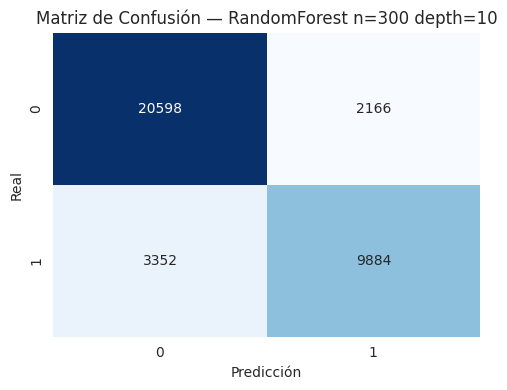

In [19]:
# Reconstruimos el mejor modelo (según el nombre)
def construir_pipeline_desde_nombre(nombre):
    if nombre.startswith("DecisionTree"):
        # extraer depth
        depth_str = nombre.split("max_depth=")[1]
        depth = None if depth_str == "None" else int(depth_str)
        return Pipeline(steps=[
            ("preprocess", preprocessor),
            ("model", DecisionTreeClassifier(max_depth=depth, random_state=42))
        ])

    if nombre.startswith("RandomForest"):
        # extraer n y depth
        # formato: "RandomForest n=100 depth=10"
        parts = nombre.replace("RandomForest ", "").split()
        n = int(parts[0].split("=")[1])
        depth_str = parts[1].split("=")[1]
        depth = None if depth_str == "None" else int(depth_str)
        return Pipeline(steps=[
            ("preprocess", preprocessor),
            ("model", RandomForestClassifier(
                n_estimators=n, max_depth=depth, random_state=42, n_jobs=-1
            ))
        ])

    raise ValueError("Nombre de modelo no reconocido.")

best_pipeline = construir_pipeline_desde_nombre(best_model_name)

best_pipeline.fit(X_train, y_train)
y_pred_best = best_pipeline.predict(X_test)

print("=== Reporte de clasificación (TEST) — Mejor modelo ===")
print(classification_report(y_test, y_pred_best, zero_division=0))

cm_best = confusion_matrix(y_test, y_pred_best)
tn, fp, fn, tp = cm_best.ravel()
print(f"\nMatriz de Confusión (TN, FP, FN, TP): {tn}, {fp}, {fn}, {tp}")

mostrar_matriz_confusion(cm_best, f"Matriz de Confusión — {best_model_name}")


# 📌 Celda 11 (Código) — Importancia de variables (solo si el mejor es RandomForest)

=== Top 10 Variables más importantes (Mejor RandomForest) ===


,Variable,Importancia
6,cat__aerolinea_G3,0.490224
21,cat__bloque_horario_noche,0.213066
7,cat__aerolinea_IB,0.043939
5,cat__aerolinea_AR,0.040050
8,cat__aerolinea_LA,0.039023
4,cat__aerolinea_AA,0.037904
19,cat__bloque_horario_madrugada,0.037172
20,cat__bloque_horario_mañana,0.030380
22,cat__bloque_horario_tarde,0.019315
0,num__distancia_km,0.019100


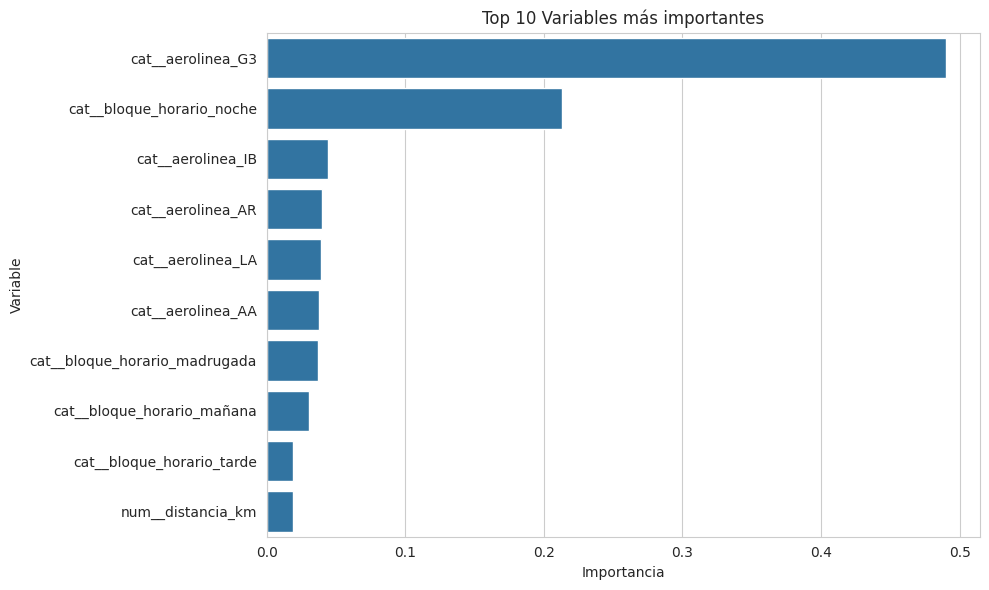

In [10]:
if best_model_name.startswith("RandomForest"):
    # obtener nombres de features post OneHot
    feature_names = best_pipeline.named_steps["preprocess"].get_feature_names_out()
    importances = best_pipeline.named_steps["model"].feature_importances_

    df_imp = pd.DataFrame({
        "Variable": feature_names,
        "Importancia": importances
    }).sort_values(by="Importancia", ascending=False)

    print("=== Top 10 Variables más importantes (Mejor RandomForest) ===")
    display(df_imp.head(10))

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importancia", y="Variable", data=df_imp.head(10))
    plt.title("Top 10 Variables más importantes")
    plt.tight_layout()
    plt.show()
else:
    print("El mejor modelo no es RandomForest; no se muestra feature importance aquí.")


# 🧠 Celda 12 (Markdown) — Resumen e insights (entregable)

## Resumen e Insights

### 1) ¿Un modelo más complejo mejora los resultados?
Se compararon Árboles de Decisión con distintas profundidades y modelos de Random Forest variando cantidad de árboles y profundidad.

El **mejor desempeño en test** se obtuvo con un **Random Forest con profundidad limitada (max_depth = 10)**, alcanzando:
- Accuracy ≈ 0.85
- F1-score ≈ 0.78

La mejora respecto a un Árbol de Decisión poco profundo es **moderada**, lo que indica que el problema presenta señales fuertes que pueden ser capturadas incluso por modelos simples. El Random Forest aporta principalmente **mayor estabilidad y robustez**, más que una mejora drástica en métricas.

---

### 2) Diferencia entre Train y Test (Overfitting)
Los modelos sin restricción de profundidad (`max_depth=None`) presentan **overfitting claro**, con performance casi perfecta en entrenamiento pero una caída significativa en test.

En cambio, tanto los Árboles de Decisión con profundidad controlada como los Random Forest muestran **valores muy similares entre train y test**, lo que indica una **buena capacidad de generalización**.

---

### 3) Análisis de la Matriz de Confusión
La matriz de confusión del mejor modelo muestra que el error predominante son los **Falsos Negativos**:
- Vuelos que efectivamente se retrasan pero el modelo no logra anticipar.

Este comportamiento se refleja en un **Recall ≈ 0.75** para la clase *retraso*. Desde el punto de vista de negocio, este tipo de error puede ser más costoso que los falsos positivos, ya que implica no alertar sobre un retraso real.

---

### 4) Variables más importantes
El análisis de *feature importance* del Random Forest indica que las variables con mayor impacto en la predicción son:
- **Aerolínea**, con un peso significativamente mayor que el resto de las variables.
- **Bloque horario**, especialmente vuelos nocturnos y de madrugada.
- **Distancia del vuelo**, con una contribución menor pero consistente.

La fuerte concentración de importancia en pocas variables sugiere que el dataset contiene **patrones dominantes**, lo que explica el buen desempeño de modelos relativamente simples.

---

### 5) Conclusión final
Los modelos no lineales permiten capturar relaciones complejas y mejorar la estabilidad de las predicciones. Sin embargo, para este problema en particular, un Árbol de Decisión poco profundo ya logra un rendimiento competitivo.

Para futuras iteraciones, podría priorizarse la reducción de **Falsos Negativos** ajustando el umbral de decisión o ponderando la clase *retraso*, en función de los objetivos del negocio.
